In [3]:
!ls

data  Untitled1.ipynb


In [2]:
%cd /content/drive/MyDrive/코드/datathon

/content/drive/MyDrive/코드/datathon


In [4]:
import pandas as pd
import numpy as np
import sys
from itertools import combinations, groupby
from collections import Counter
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings(action='ignore')
%matplotlib inline

In [5]:
aisles = pd.read_csv('./data/aisles.csv')  #(134, 2)
departments = pd.read_csv('./data/departments.csv') #(21, 2)
products = pd.read_csv('./data/products.csv') # (49688, 4)
order_products_prior = pd.read_csv('./data/order_products__prior.csv') #(32434489, 4)
order_products_train = pd.read_csv('./data/order_products__train.csv') #(1384617, 4)
orders = pd.read_csv('./data/orders.csv') #(3421083, 7)

In [6]:
order_products_prior = order_products_prior.set_index('order_id')['product_id'].rename('item_id')
display(order_products_prior.head(10))
type(order_products_prior)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

In [7]:
# Returns frequency counts for items and item pairs
def freq(iterable):
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
# Returns number of unique orders
def order_count(order_item):
    return len(set(order_item.index))


# Returns generator that yields item pairs, one at a time
def get_item_pairs(order_item):
    order_item = order_item.reset_index().values
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            

# Returns frequency and support associated with item
def merge_item_stats(item_pairs, item_stats):
    return (item_pairs
                .merge(item_stats.rename(columns={'freq': 'freqA', 'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(columns={'freq': 'freqB', 'support': 'supportB'}), left_on='item_B', right_index=True))


# Returns name associated with item
def merge_item_name(rules, item_name):
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), left_on='item_B', right_on='item_id'))
    return rules[columns]              

In [8]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))


    # Calculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Filter from order_item items below min support 
    qualifying_items       = item_stats[item_stats['support'] >= min_support].index
    order_item             = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Filter from order_item orders with less than 2 items
    order_size             = freq(order_item.index)
    qualifying_orders      = order_size[order_size >= 2].index
    order_item             = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))


    # Recalculate item frequency and support
    item_stats             = freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100


    # Get item pairs generator
    item_pair_gen          = get_item_pairs(order_item)


    # Calculate item pair frequency and support
    item_pairs              = freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))


    # Filter from item_pairs those below min support
    item_pairs              = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))


    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift']           = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])
    
    
    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

In [9]:
rules = association_rules(order_products_prior, 0.01) 

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716
Item pairs:                        30622410
Item pairs with support >= 0.01:      48751



In [10]:
# Replace item ID with item name and display association rules
products = products.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, products).sort_values('lift', ascending=False)
display(rules_final)

,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
...,...,...,...,...,...,...,...,...,...,...,...
7271,Organic Strawberries,Strawberries,640,0.021239,263416,8.741706,141805,4.705931,0.002430,0.004513,0.000516
6763,Organic Hass Avocado,Organic Avocado,464,0.015398,212785,7.061469,176241,5.848722,0.002181,0.002633,0.000373
4387,Organic Avocado,Organic Hass Avocado,443,0.014701,176241,5.848722,212785,7.061469,0.002514,0.002082,0.000356
2596,Banana,Bag of Organic Bananas,654,0.021704,470096,15.600574,376367,12.490090,0.001391,0.001738,0.000111


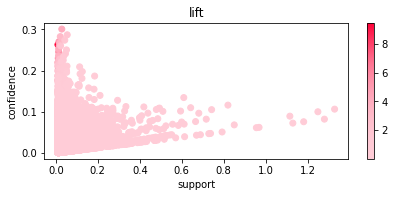

In [14]:
# 시각화 해보자.
import matplotlib.pyplot as plt
import matplotlib.colors as mcl
from matplotlib.colors import LinearSegmentedColormap


support = rules_final['supportAB']
confidence = rules_final['confidenceAtoB']
rules
h = 347
s = 1
v = 1
colors = [
    mcl.hsv_to_rgb((h/360, 0.2, v)),
    mcl.hsv_to_rgb((h/360, 0.55, v)),
    mcl.hsv_to_rgb((h/360, 1, v))
]
cmap = LinearSegmentedColormap.from_list('my_cmap',colors,gamma=2)
 
measures = ['lift']
 
fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')
for i, measure in enumerate(measures):
    ax = fig.add_subplot(320+i+1)
    if measure != 'all-confidence':
        scatter = ax.scatter(support,confidence,c=rules_final[measure],cmap=cmap)
    else:
        scatter = ax.scatter(support,confidence,c=rules_final['all-confidence'].map(lambda x: [v for k,v in x.items()][0]),cmap=cmap)
    ax.set_xlabel('support')
    ax.set_ylabel('confidence')
    ax.set_title(measure)
    
    fig.colorbar(scatter,ax=ax)
fig.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [30]:
rules.to_csv('./rules.csv')
rules_final.to_csv('./rules_final.csv')

In [23]:
# 음 그래프가 직관적으로 뭘 의미하는지 모르겠다..? 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycaret-1.0.0-py3-none-any.whl (188 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 KB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.0/379.0 KB 13.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement catboost==0.20.2 (from pycaret) (from versions: 0.24.4, 0.25, 0.25.1, 0.26, 0.26.1, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.1, 1.1.1)
ERROR: No matching distribution found for catboost==0.20.2


In [39]:
import networkx as nx

G = nx.Graph()
G.add_edges_from(rules_final['itemA'])

NetworkXError: ignored

In [34]:
s = setup(data = rules_final, transaction_id = 'itemA', item_id = 'itemB')

# train model
a_rules = clustering.create_model(metric='confidence', threshold=0.5, min_support=0.01)

# 2d plot
clustering.plot_model(a_rules, plot = '2d')


NameError: ignored